In [1]:
# Create IRS/lists/IRS_metal_test.list for our usage
from pathlib import Path

OG_LIST = 'IRS/lists/IRS_metal_test.list'
NEW_LIST = 'IRS/lists/IRS_restaurant_metal_test.list'

to_write = []
with Path(OG_LIST).open('r') as all_list:
    lines = all_list.readlines()
    for line in lines:
        if "restaurant" not in line:
            continue
        to_write.append(line.replace('SIRSDataset/restaurant', 'Restaurant'))

with Path(NEW_LIST).open('w') as f:
    for item in to_write:
        f.write("%s" % item)

DEVICE = 'cpu'
DEVICE = 'cuda:0'




/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


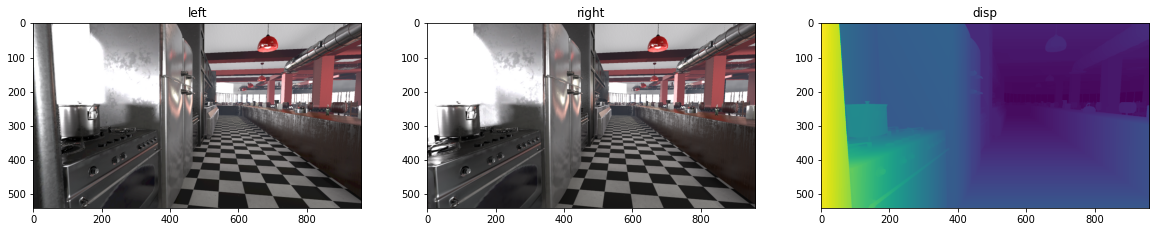

In [2]:
# Load the IRS/lists/IRS_metal_test.list file into the IRSDataset
%load_ext autoreload
%autoreload 2

from IRS.dataloader.IRSLoader import IRSDataset
import matplotlib.pyplot as plt
import torch


DATA_DIR = "/data"
dataset = IRSDataset(txt_file=NEW_LIST, root_dir=DATA_DIR, phase='visualize')
# good: 8, 12, 15, 26
sample = dataset[26]
# sample = torch.utils.data.Subset(dataset, range(8,9))[0]
im_l, im_r, disp = sample['img_left'].to(DEVICE), sample['img_right'].to(DEVICE), sample['gt_disp'].to(DEVICE)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1,3,1)
plt.title('left')
ax1.imshow(im_l.cpu().moveaxis(0, -1))
ax2 = fig.add_subplot(1,3,2)
plt.title('right')
ax2.imshow(im_r.cpu().moveaxis(0, -1))
ax3 = fig.add_subplot(1,3,3)
plt.title('disp')
ax3.imshow(disp.cpu().moveaxis(0, -1))

In [12]:
from collections import defaultdict
from typing import Dict, Callable
from tqdm import tqdm
import torch
import torch.nn as nn

def SSIM(x, y):
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    mu_x = nn.AvgPool2d(3, 1,1)(x)
    mu_y = nn.AvgPool2d(3, 1,1)(y)
    mu_x_mu_y = mu_x * mu_y
    mu_x_sq = mu_x.pow(2)
    mu_y_sq = mu_y.pow(2)

    sigma_x  = nn.AvgPool2d(3, 1,1)(x * x) - mu_x_sq
    sigma_y  = nn.AvgPool2d(3, 1,1)(y * y) - mu_y_sq
    sigma_xy = nn.AvgPool2d(3, 1,1)(x * y) - mu_x_mu_y

    SSIM_n = (2 * mu_x_mu_y + C1) * (2 * sigma_xy + C2)
    SSIM_d = (mu_x_sq + mu_y_sq + C1) * (sigma_x + sigma_y + C2)
    SSIM = SSIM_n / SSIM_d

    return torch.clamp((1 - SSIM) / 2, 0, 1)

def estimate_right(im_l, im_r, disp, dist_fn=None):
    '''
    im_l: [C(3), H, W]
    disp: [C(1), H, W]
    '''
    K = torch.tensor([[480, 0, 270], [0, 480, 480], [0, 0, 1]]).type_as(im_l).to(im_l.device)
    _, h, w = im_l.shape
    x_base = torch.linspace(0, w-1, w).repeat(h, 1).to(im_l.device)
    y_base = torch.linspace(0, h-1, h).repeat(w, 1).transpose(0, 1).to(im_l.device)
    # [H, W, 3]
    im_norm = (K.inverse() @ torch.stack((x_base, y_base, torch.ones_like(y_base)), dim=2).unsqueeze(-1)).squeeze()
    depth = ((0.1 * 480) / disp).moveaxis(0, -1)
    if dist_fn is not None:
        depth = dist_fn(depth=depth) # (depth_variance**0.5)*torch.randn_like(depth)
    im_3d = im_norm * depth
    homo_im_3d = torch.concat((im_3d, torch.ones_like(depth)), dim=2)
    P = K @ torch.concat([torch.eye(3), torch.tensor([-0.1, 0, 0]).unsqueeze(1)], dim=1).to(im_l.device)
    homo_im_r_coords = (P @ homo_im_3d.unsqueeze(-1)).squeeze()
    im_r_coords = (homo_im_r_coords / homo_im_r_coords[:,:,-1].unsqueeze(-1))[:,:,:2]
    x = torch.zeros_like(im_r)
    x[2,:,:] = 1
    x = x.swapaxes(0, -1)
    # [N, 2]
    index = im_r_coords.flatten(0,1).round().long().clip(0, 959)
    # [N, 3]
    values = im_l.moveaxis(0,-1).flatten(0,1)
    # [N, 1]
    depth_order = depth.flatten(0,1).squeeze().sort().indices
    # first sort by depth order
    values = values.index_select(0, depth_order)
    index = index.index_select(0, depth_order)
    # index = tuple(.t())
    # then secondary sort by index order
    index_order = (index.select(1,0) * 1000 + index.select(1,1)).sort(stable=True).indices
    values = values.index_select(0, index_order)
    index = index.index_select(0, index_order)
    # only keep first indices, which are the ones with the smallest depth
    keep_mask = (index.roll(shifts=1, dims=0) - index).sum(dim=1) != 0
    index, values = index[keep_mask], values[keep_mask]
    
    index = tuple(index.t())
    est_r_occ = torch.index_put(x, index, values).swapaxes(0,1).moveaxis(-1, 0)
    valid_mask = torch.index_put(torch.zeros_like(x, dtype=torch.bool), index, torch.ones_like(values, dtype=torch.bool)).swapaxes(0,1).moveaxis(-1, 0)
    est_r = torch.where(valid_mask, est_r_occ, im_r)
    return est_r_occ, est_r

def estimate_left(im_l, im_r, disp):
    '''
    im_r: [3, H, W]
    '''
    h, w = im_r.shape[1:]
    x_base = torch.linspace(0, w-1, w).repeat(h, 1).to(im_r.device)
    # [1, H, W]
    x_query = (x_base - disp).round().long()
    valid_mask = x_query >= 0
    return torch.where(valid_mask, im_r.gather(2, x_query.clip(0, 959).expand_as(im_r)), im_l)

def eval_loss_functions(loss_fns: Dict[str, Callable], dist_fns: Dict[str, Callable], dataset: IRSDataset):
    '''
    Returns a dict of quality ratios, smaller the better the loss function
    '''
    loss_dist = defaultdict(lambda: defaultdict(list))
    for sample in tqdm(dataset):
        im_l, im_r, disp = sample['img_left'].to(DEVICE), sample['img_right'].to(DEVICE), sample['gt_disp'].to(DEVICE)
        _, est_r = estimate_right(im_l, im_r, disp)
        for dist_fn_name, dist_fn in dist_fns.items():
            _, dist_est_r = estimate_right(im_l, im_r, disp, dist_fn=dist_fn)
            for loss_fn_name, loss_fn in loss_fns.items():
                loss_dist[loss_fn_name][dist_fn_name].append((loss_fn(im_r, dist_est_r) / loss_fn(im_r, est_r)).item())
    return {kloss: {kdist: (sum(vdist) / len(vdist)) for kdist, vdist in vloss.items()} for kloss,vloss in loss_dist.items()}


In [10]:
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True).to(DEVICE)
vgg16cpu = models.vgg16(pretrained=True)

feat_gen = list(vgg16.named_children())[0][1]
feat_gencpu = list(vgg16cpu.named_children())[0][1]
l0 = 0
l1 = 4
l2 = 9
l3 = 16
l4 = 30
def perceptual_loss(est, gt, layer=l1):
    '''
    est: [3, H, W]
    gt: [3, H, W]
    '''
    est_per = feat_gen[l0:layer](est.unsqueeze(0)).squeeze()
    
    gt_per = feat_gen[l0:layer](gt.unsqueeze(0)).squeeze()
    # return torch.abs(est_l1 - gt_l1).mean()
    return torch.norm(est_per - gt_per,p=1,dim=0).mean()

def perceptual_loss_img(est, gt, layer=l1):
    '''
    est: [3, H, W]
    gt: [3, H, W]
    '''
    est_per = feat_gen.to(DEVICE)[l0:layer](est.unsqueeze(0)).detach().squeeze()
    gt_per = feat_gen.to(DEVICE)[l0:layer](gt.unsqueeze(0)).detach().squeeze()
    # return torch.abs(est_l1 - gt_l1).mean()
    return torch.norm(est_per - gt_per,p=1,dim=0)



In [7]:
from functools import partial
l1_loss_fn = lambda gt, est: torch.norm(est - gt,p=1,dim=0).mean()
ssim_loss_fn = lambda gt, est: (torch.norm(SSIM(est, gt),p=1,dim=0) ** 1).mean()
dist_gauss = lambda depth, variance: depth + (variance**0.5)*torch.randn_like(depth)
norm_loss = lambda loss: ((loss - loss.min()) / loss.max())
min_l1_per1_loss = lambda gt, est: torch.min(norm_loss(torch.norm(SSIM(est, gt),p=1,dim=0)), norm_loss(perceptual_loss_img(gt, est, layer=l1))).mean()
def l4_loss(gt, est):
        ssim = torch.norm(SSIM(est, gt),p=1,dim=0)
        per1 = perceptual_loss_img(gt, est, layer=l1)
        per2 = perceptual_loss_img(gt, est, layer=l2)
        per3 = perceptual_loss_img(gt, est, layer=l3)
        per4 = perceptual_loss_img(gt, est, layer=l4)
        up_per1 = torch.nn.Upsample(size=ssim.shape)(per1.unsqueeze(0).unsqueeze(0)).squeeze()
        up_per2 = torch.nn.Upsample(size=ssim.shape)(per2.unsqueeze(0).unsqueeze(0)).squeeze()
        up_per3 = torch.nn.Upsample(size=ssim.shape)(per3.unsqueeze(0).unsqueeze(0)).squeeze()
        up_per4 = torch.nn.Upsample(size=ssim.shape)(per4.unsqueeze(0).unsqueeze(0)).squeeze()
        return (norm_loss(up_per1) * norm_loss(up_per2) * norm_loss(up_per3) * norm_loss(up_per4)).mean()

def ssim_l4_loss(gt, est):
        ssim = torch.norm(SSIM(est, gt),p=1,dim=0)
        per1 = perceptual_loss_img(gt, est, layer=l1)
        per2 = perceptual_loss_img(gt, est, layer=l2)
        per3 = perceptual_loss_img(gt, est, layer=l3)
        per4 = perceptual_loss_img(gt, est, layer=l4)
        up_per1 = torch.nn.Upsample(size=ssim.shape)(per1.unsqueeze(0).unsqueeze(0)).squeeze()
        up_per2 = torch.nn.Upsample(size=ssim.shape)(per2.unsqueeze(0).unsqueeze(0)).squeeze()
        up_per3 = torch.nn.Upsample(size=ssim.shape)(per3.unsqueeze(0).unsqueeze(0)).squeeze()
        up_per4 = torch.nn.Upsample(size=ssim.shape)(per4.unsqueeze(0).unsqueeze(0)).squeeze()
        return (ssim * norm_loss(up_per1) * norm_loss(up_per2) * norm_loss(up_per3) * norm_loss(up_per4)).mean()

def ssim_l1_loss(gt, est):
        ssim = torch.norm(SSIM(est, gt),p=1,dim=0)
        per1 = perceptual_loss_img(gt, est, layer=l1)
        per2 = perceptual_loss_img(gt, est, layer=l2)
        per3 = perceptual_loss_img(gt, est, layer=l3)
        per4 = perceptual_loss_img(gt, est, layer=l4)
        up_per1 = torch.nn.Upsample(size=ssim.shape)(per1.unsqueeze(0).unsqueeze(0)).squeeze()
        up_per2 = torch.nn.Upsample(size=ssim.shape)(per2.unsqueeze(0).unsqueeze(0)).squeeze()
        up_per3 = torch.nn.Upsample(size=ssim.shape)(per3.unsqueeze(0).unsqueeze(0)).squeeze()
        up_per4 = torch.nn.Upsample(size=ssim.shape)(per4.unsqueeze(0).unsqueeze(0)).squeeze()
        return (ssim * (norm_loss(up_per1) ** 4)).mean()

def ssim_l2_loss(gt, est):
        ssim = torch.norm(SSIM(est, gt),p=1,dim=0)
        per1 = perceptual_loss_img(gt, est, layer=l1)
        per2 = perceptual_loss_img(gt, est, layer=l2)
        per3 = perceptual_loss_img(gt, est, layer=l3)
        per4 = perceptual_loss_img(gt, est, layer=l4)
        up_per1 = torch.nn.Upsample(size=ssim.shape)(per1.unsqueeze(0).unsqueeze(0)).squeeze()
        up_per2 = torch.nn.Upsample(size=ssim.shape)(per2.unsqueeze(0).unsqueeze(0)).squeeze()
        up_per3 = torch.nn.Upsample(size=ssim.shape)(per3.unsqueeze(0).unsqueeze(0)).squeeze()
        up_per4 = torch.nn.Upsample(size=ssim.shape)(per4.unsqueeze(0).unsqueeze(0)).squeeze()
        return (ssim * norm_loss(up_per1) * norm_loss(up_per2)).mean()

def ssim_l3_loss(gt, est):
        ssim = torch.norm(SSIM(est, gt),p=1,dim=0)
        per1 = perceptual_loss_img(gt, est, layer=l1)
        per2 = perceptual_loss_img(gt, est, layer=l2)
        per3 = perceptual_loss_img(gt, est, layer=l3)
        per4 = perceptual_loss_img(gt, est, layer=l4)
        up_per1 = torch.nn.Upsample(size=ssim.shape)(per1.unsqueeze(0).unsqueeze(0)).squeeze()
        up_per2 = torch.nn.Upsample(size=ssim.shape)(per2.unsqueeze(0).unsqueeze(0)).squeeze()
        up_per3 = torch.nn.Upsample(size=ssim.shape)(per3.unsqueeze(0).unsqueeze(0)).squeeze()
        up_per4 = torch.nn.Upsample(size=ssim.shape)(per4.unsqueeze(0).unsqueeze(0)).squeeze()
        return (ssim * norm_loss(up_per1) * norm_loss(up_per2) * norm_loss(up_per3)).mean()

loss_fns = {'l1': l1_loss_fn, 
        'ssim': ssim_loss_fn, 
        # 'perceptual_l1': partial(perceptual_loss, layer=l1),
        # 'perceptual_l2': partial(perceptual_loss, layer=l2),
        # 'perceptual_l3': partial(perceptual_loss, layer=l3),
        # 'perceptual_l4': partial(perceptual_loss, layer=l4),
        'l4_loss': l4_loss,
        'ssim_l4_loss': ssim_l4_loss,
        'ssim_l1_loss': ssim_l1_loss,
        'ssim_l2_loss': ssim_l2_loss,
        'ssim_l3_loss': ssim_l3_loss,}
dist_fns = {
        'guass_0.0': partial(dist_gauss, variance=0.0),
        'guass_0.001': partial(dist_gauss, variance=0.001),
        'guass_0.01': partial(dist_gauss, variance=0.01),
        'guass_0.1': partial(dist_gauss, variance=0.1),
        'guass_1': partial(dist_gauss, variance=1), 
        'guass_10': partial(dist_gauss, variance=10),
        'guass_100': partial(dist_gauss, variance=100)}
results = eval_loss_functions(
    loss_fns=loss_fns, 
    dist_fns=dist_fns,
    dataset=torch.utils.data.Subset(dataset, range(0,5)))

100%|██████████| 5/5 [00:29<00:00,  5.99s/it]


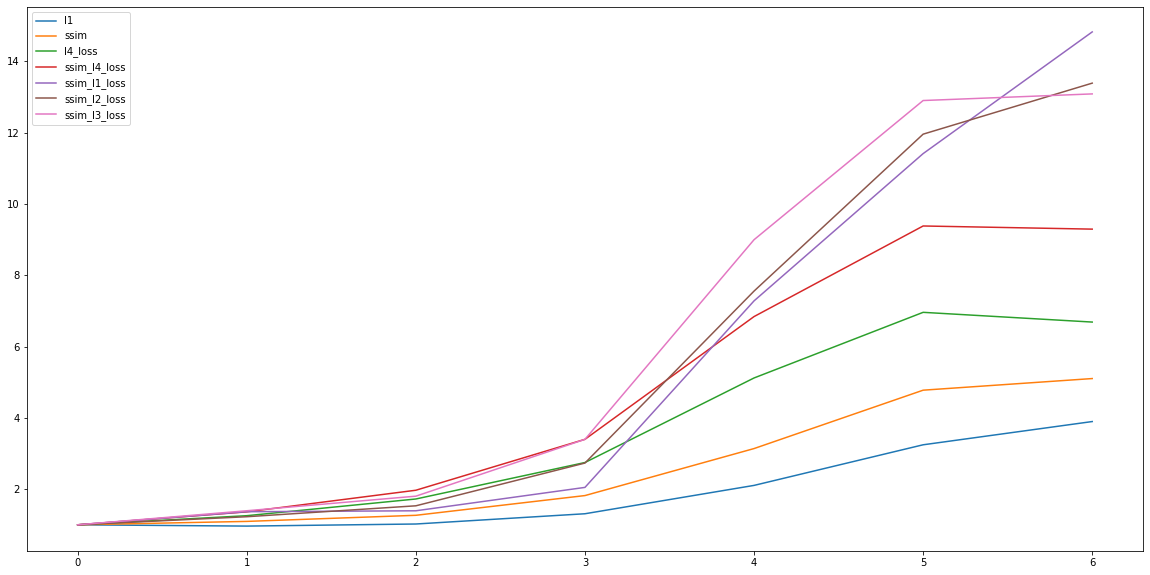

In [8]:
plt.figure(figsize=(20,10))
for loss_fn_name in loss_fns.keys():
    plt.plot([results[loss_fn_name]['guass_0.0'], results[loss_fn_name]['guass_0.001'],results[loss_fn_name]['guass_0.01'],results[loss_fn_name]['guass_0.1'], results[loss_fn_name]['guass_1'], results[loss_fn_name]['guass_10'], results[loss_fn_name]['guass_100']], label = loss_fn_name)
plt.legend()

100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


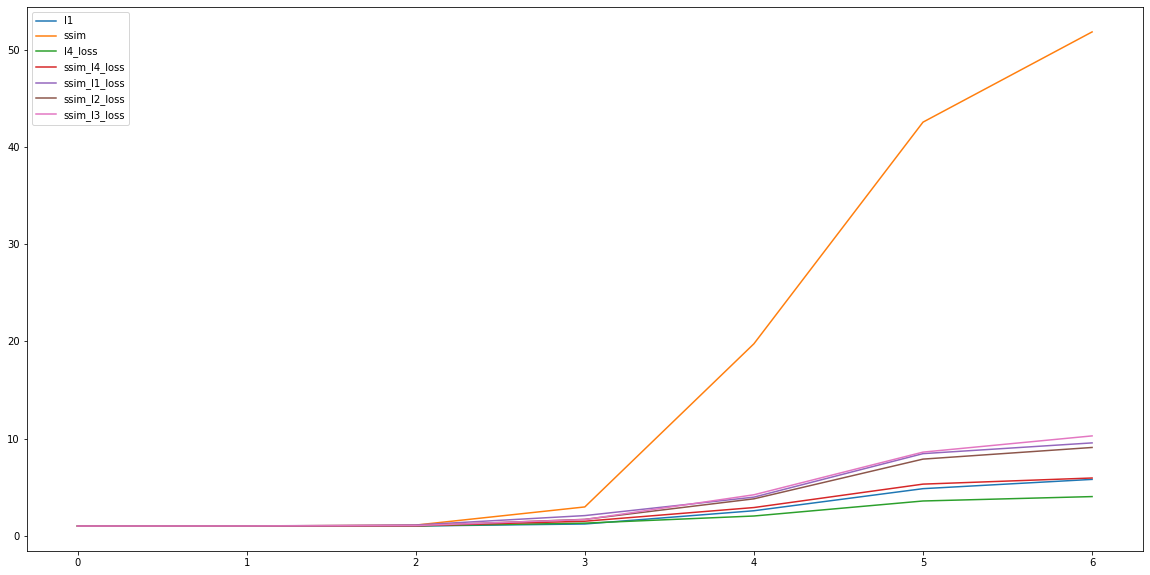

In [75]:
dist_shift = lambda depth, shift: depth + shift

dist_fns = {
        'guass_0.0': partial(dist_shift, shift=0.0),
        'guass_0.001': partial(dist_shift, shift=0.001),
        'guass_0.01': partial(dist_shift, shift=0.01),
        'guass_0.1': partial(dist_shift, shift=0.1),
        'guass_1': partial(dist_shift, shift=1), 
        'guass_10': partial(dist_shift, shift=10),
        'guass_100': partial(dist_shift, shift=100)}
shift_results = eval_loss_functions(
    loss_fns=loss_fns, 
    dist_fns=dist_fns,
    dataset=torch.utils.data.Subset(dataset, range(0,5)))
plt.figure(figsize=(20,10))
for loss_fn_name in loss_fns.keys():
    plt.plot([shift_results[loss_fn_name]['guass_0.0'], shift_results[loss_fn_name]['guass_0.001'],shift_results[loss_fn_name]['guass_0.01'],shift_results[loss_fn_name]['guass_0.1'], shift_results[loss_fn_name]['guass_1'], shift_results[loss_fn_name]['guass_10'], shift_results[loss_fn_name]['guass_100']], label = loss_fn_name)
plt.legend()

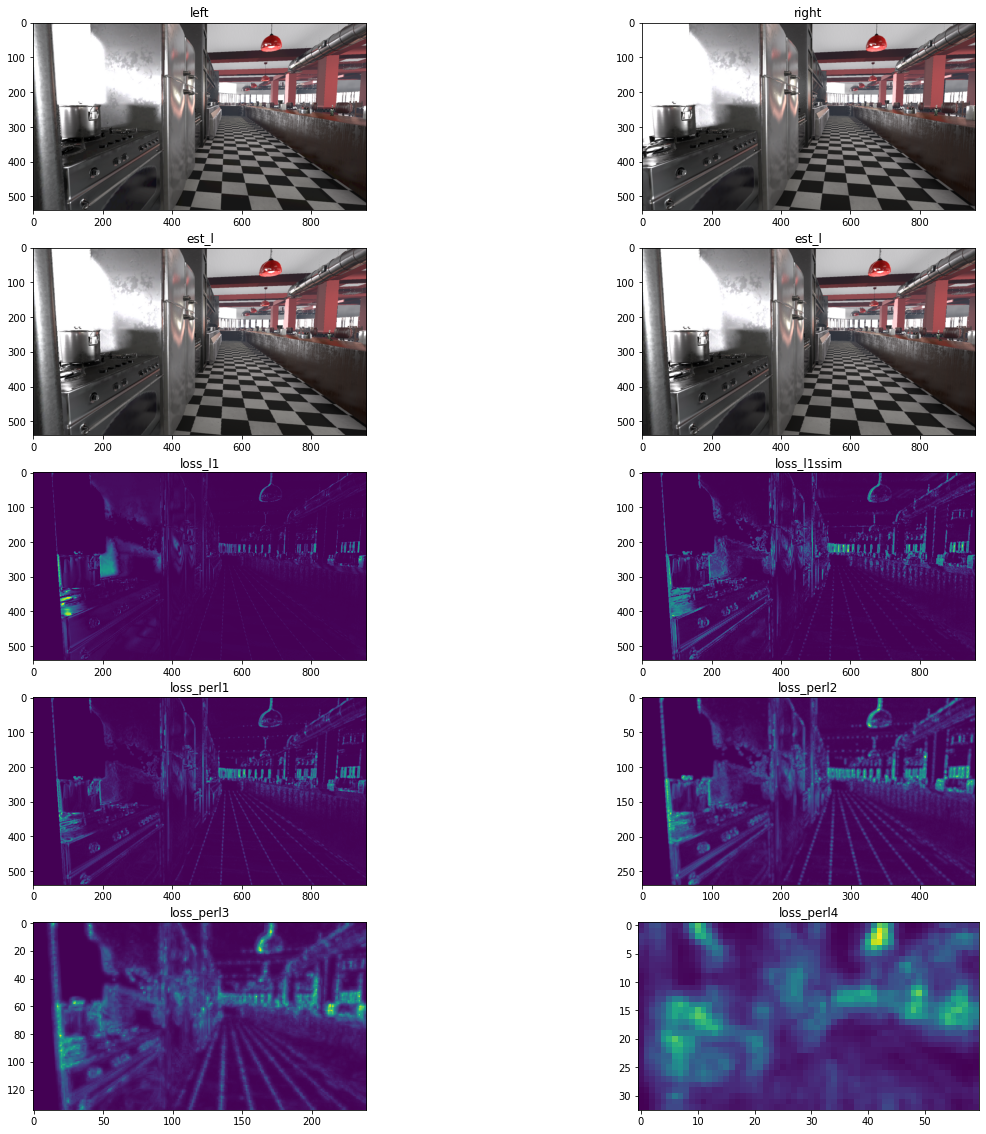

In [15]:
est_l = estimate_left(im_l.to(DEVICE), im_r.to(DEVICE), disp.to(DEVICE))
l1_loss = torch.abs(est_l - im_l.to(DEVICE)).norm(dim=0)
ssim_loss = SSIM(est_l, im_l.to(DEVICE)).norm(dim=0)
def perceptual_loss_img(est, gt, layer=l1):
    '''
    est: [3, H, W]
    gt: [3, H, W]
    '''
    est_per = feat_gen.to(DEVICE)[l0:layer](est.unsqueeze(0)).detach()
    gt_per = feat_gen.to(DEVICE)[l0:layer](gt.unsqueeze(0)).detach()
    # return torch.abs(est_l1 - gt_l1).mean()
    return torch.norm(est_per - gt_per,p=2,dim=0)
perl1_loss = perceptual_loss_img(est_l, im_l.to(DEVICE)).norm(dim=0)
perl2_loss = perceptual_loss_img(est_l, im_l.to(DEVICE), layer=l2).norm(dim=0)
perl3_loss = perceptual_loss_img(est_l, im_l.to(DEVICE), layer=l3).norm(dim=0)
perl4_loss = perceptual_loss_img(est_l, im_l.to(DEVICE), layer=l4).norm(dim=0)


fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(5,2,1)
plt.title('left')
ax1.imshow(im_l.cpu().moveaxis(0, -1))
ax2 = fig.add_subplot(5,2,2)
plt.title('right')
ax2.imshow(im_r.cpu().moveaxis(0, -1))
ax3 = fig.add_subplot(5,2,3)
plt.title('est_l')
ax3.imshow(est_l.cpu().moveaxis(0, -1))
ax3 = fig.add_subplot(5,2,4)
plt.title('est_l')
ax3.imshow(est_l.cpu().moveaxis(0, -1))
ax3 = fig.add_subplot(5,2,5)
plt.title('loss_l1')
ax3.imshow(l1_loss.cpu().squeeze().cpu())
ax3 = fig.add_subplot(5,2,6)
plt.title('loss_l1ssim')
ax3.imshow(ssim_loss.cpu().squeeze().cpu())
ax3 = fig.add_subplot(5,2,7)
plt.title('loss_perl1')
ax3.imshow(perl1_loss.cpu().squeeze().cpu())
ax3 = fig.add_subplot(5,2,8)
plt.title('loss_perl2')
ax3.imshow(perl2_loss.cpu().squeeze().cpu())
ax3 = fig.add_subplot(5,2,9)
plt.title('loss_perl3')
ax3.imshow(perl3_loss.cpu().squeeze().cpu())
ax3 = fig.add_subplot(5,2,10)
plt.title('loss_perl4')
ax3.imshow(perl4_loss.cpu().squeeze().cpu())


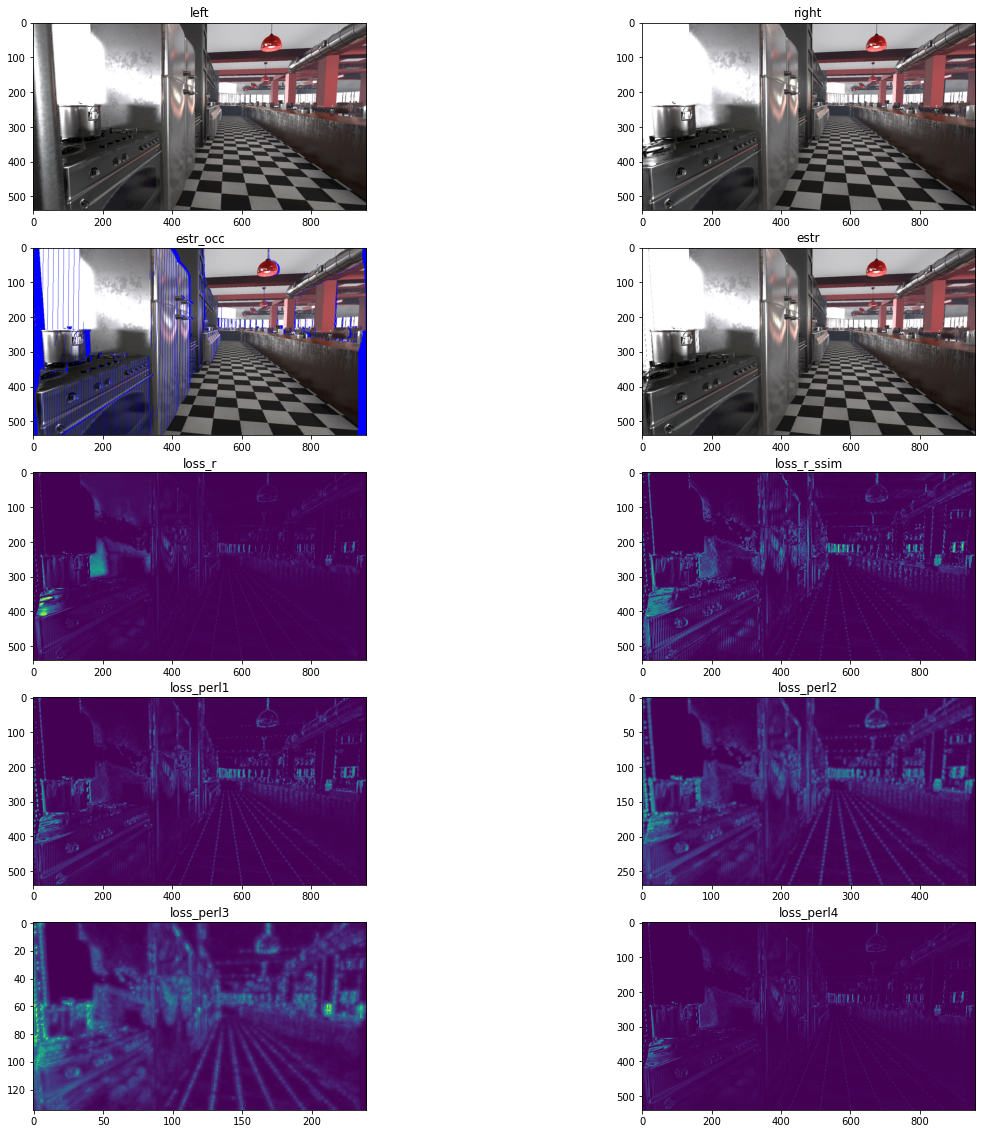

In [8]:
%matplotlib inline
est_r_occ, est_r = estimate_right(im_l.to(DEVICE), im_r.to(DEVICE), disp.to(DEVICE))
dist_est_r_occ, dist_est_r = estimate_right(im_l.to(DEVICE), im_r.to(DEVICE), disp.to(DEVICE), dist_fn=partial(dist_gauss, variance=1))
l1_loss, dist_l1_loss = torch.abs(est_r - im_r.to(DEVICE)).norm(dim=0), torch.abs(dist_est_r - im_r.to(DEVICE))
ssim_loss, dist_ssim_loss = SSIM(est_r, im_r.to(DEVICE)).norm(dim=0), SSIM(dist_est_r, im_r.to(DEVICE))
def perceptual_loss_img(est, gt, layer=l1):
    '''
    est: [3, H, W]
    gt: [3, H, W]
    '''
    est_per = feat_gen.to(DEVICE)[l0:layer](est.unsqueeze(0)).detach()
    gt_per = feat_gen.to(DEVICE)[l0:layer](gt.unsqueeze(0)).detach()
    # return torch.abs(est_l1 - gt_l1).mean()
    return torch.norm(est_per - gt_per,p=2,dim=0)
perl1_loss = perceptual_loss_img(est_r, im_r.to(DEVICE)).norm(dim=0)
perl2_loss = perceptual_loss_img(est_r, im_r.to(DEVICE), layer=l2).norm(dim=0)
perl3_loss = perceptual_loss_img(est_r, im_r.to(DEVICE), layer=l3).norm(dim=0)
perl4_loss = perceptual_loss_img(est_r, im_r.to(DEVICE), layer=l4).norm(dim=0)

norm_loss = lambda loss: ((loss - loss.min()) / loss.max())
perl4_loss = torch.min(norm_loss(l1_loss), norm_loss(perl1_loss))

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(5,2,1)
plt.title('left')
ax1.imshow(im_l.cpu().moveaxis(0, -1))
ax2 = fig.add_subplot(5,2,2)
plt.title('right')
ax2.imshow(im_r.cpu().moveaxis(0, -1))
ax3 = fig.add_subplot(5,2,3)
plt.title('estr_occ')
ax3.imshow(est_r_occ.cpu().moveaxis(0, -1))
ax3 = fig.add_subplot(5,2,4)
plt.title('estr')
ax3.imshow(est_r.cpu().moveaxis(0, -1))
ax3 = fig.add_subplot(5,2,5)
plt.title('loss_r')
ax3.imshow(l1_loss.cpu().squeeze().cpu())
ax3 = fig.add_subplot(5,2,6)
plt.title('loss_r_ssim')
ax3.imshow(ssim_loss.cpu().squeeze().cpu())
ax3 = fig.add_subplot(5,2,7)
plt.title('loss_perl1')
ax3.imshow(perl1_loss.cpu().squeeze().cpu())
ax3 = fig.add_subplot(5,2,8)
plt.title('loss_perl2')
ax3.imshow(perl2_loss.cpu().squeeze().cpu())
ax3 = fig.add_subplot(5,2,9)
plt.title('loss_perl3')
ax3.imshow(perl3_loss.cpu().squeeze().cpu())
ax3 = fig.add_subplot(5,2,10)
plt.title('loss_perl4')
ax3.imshow(perl4_loss.cpu().squeeze().cpu())